<a href="https://colab.research.google.com/github/jarinari/Algorithmic-Trading-Plugins/blob/master/metricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INTRODUCCIÓN

En este Colab se analiza la relación entre las métricas que se obtienen en backtest y el rendimiento de la estrategia en forward.

Para ello se realizará lo siguiente:

1) generación de 10.000 estrategias correspondientes a los estimadores generados con Random Forest en un periodo de entrenamiento de 7 años

2) cálculo de métricas para cada una de las estrategias en un periodo de prueba de 3 años

3) cálculo de una métrica diana para cada una de las estrategias en un periodo de forward de 3 años

Los periodos mencionados serán los siguientes:

- train: 01/01/2010 - 01/01/2017
- test: 01/01/2017 - 01/01/2020
- forward: 01/01/2020 - 01/01/2023

Las estrategias serán reglas construidas con los siguientes indicadores técnicos disponibles en la librería pandas_ta: CCI, ATR, RSI, Williams %R, ADX, Momentum, RVI y media móvil.

Cada uno de los indicadores será calculado para un rango de parámetros.

El etiquetado para la extracción de las reglas será el "Método de la Triple Barrera" de Marcos López de Prado a 1 día vista y con un umbral del 0.10%, lo que generará las siguientes clases:

- 1: si el precio sube un 0.10% o más durante la sesión
- -1: si el precio baja un -0.10% o más durante la sesión
- 0: si acaba la sesión sin producirse ninguna de las clases anteriores

#ENTORNO

##DATOS

El activo utilizado en este código será el EURUSD en diario disponible en los siguientes enlaces:

- descarga: https://drive.google.com/uc?id=1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ

- visualización: https://drive.google.com/file/d/1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ/view?usp=sharing

##LIBRERÍAS

In [ ]:
#INSTALACIÓN DE LIBRERÍA PARA CALCULAR INDICADORES TÉCNICOS
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=bfadc5f6642e8004c89ec66b52a7ee460c8cc72474a0f2ba70ae1f16b0e8becf
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
#IMPORTACIÓN DE LIBRERÍAS
import pandas_ta as ta
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

##FUNCIONES

In [ ]:
#FUNCIÓN PARA OBTENER LOS DATOS

def get_data(url):
  """
  Descarga un archivo CSV desde una URL y devuelve los datos como un DataFrame.

  Parámetros:
  url (str): La URL del archivo CSV a descargar.

  Retorna:
  pandas.DataFrame: Un DataFrame que contiene los datos del archivo CSV.
  """

  #Descargar el archivo
  output = "archivo.csv"
  gdown.download(url, output, quiet=False)

  #Leer el archivo descargado
  data = pd.read_csv(output)

  return data

In [ ]:
#FUNCIÓN PARA CALCULAR INDICADORES TÉCNICOS

def calculate_indicators(data):
  """
  Calcula indicadores técnicos para los datos de precios de un activo específico.

  Args:
    data (pandas.DataFrame): Datos históricos del activo.

  Returns:
    pandas.DataFrame: Un DataFrame que contiene los indicadores calculados.
  """

  #Renombrar las columnas
  data.columns = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"]
  #Establecer la fecha como índice
  data = data.set_index("Date")
  #Eliminar columnas innecesarias
  data = data.drop(["Time", "Volume"], axis=1)

  #Extraer columnas necesarias para el cálculo de indicadores
  close = data["Close"]
  high = data["High"]
  low = data["Low"]

  #Crear de listas para guardar el nombre de los indicadores y los valores
  indicators = []
  columns = []

  #Establecer rango de valores usados como parámetro para el cálculo de los indicadores
  periods = list(range(5,100))

  #CCI - Commodity Channel Index
  for n in periods:
    name = "CCI" + str(n)
    indicators.append(ta.cci(high, low, close, n))
    columns.append(name)
  #NORMALIZED AVERANGE TRUE RANGE
  for n in periods:
    name = "NATR" + str(n)
    indicators.append(ta.natr(high, low, close, n))
    columns.append(name)
  #RSI - Relative Strength Index
  for n in periods:
    name = "RSI" + str(n)
    indicators.append(ta.rsi(close, n))
    columns.append(name)
  #WILLR - Williams' %R
  for n in periods:
    name = "WILLR" + str(n)
    indicators.append(ta.willr(high, low, close, n))
    columns.append(name)
  #ADX
  for n in periods:
    adx = ta.adx(high, low, close, n)
    name = "ADX" + str(n)
    indicators.append(adx["ADX_"+str(n)])
    columns.append(name)
    name = "DMP" + str(n)
    indicators.append(adx["DMP_"+str(n)])
    columns.append(name)
    name = "DMN" + str(n)
    indicators.append(adx["DMN_"+str(n)])
    columns.append(name)
  #MOMENTUM
  for n in periods:
    name = "MOM" + str(n)
    indicators.append(ta.mom(close, n))
    columns.append(name)
  #RVI
  for n in periods:
    name = "RVI" + str(n)
    indicators.append(ta.rvi(close, n))
    columns.append(name)
  #SMA CLOSE RELATIVE
  for n in periods:
    name = "Close/SMA" + str(n)
    sma = ta.sma(close, n)
    indicators.append(close/sma)
    columns.append(name)
  #SMA SMA5 RELATIVE
  for n in periods:
    name = "SMA5/SMA" + str(n)
    sma5 = ta.sma(close, 5)
    sma = ta.sma(close, n)
    indicators.append(sma5/sma)
    columns.append(name)
  #ATR CLOSE RELATIVE
  for n in periods:
    name = "Close/ATR" + str(n)
    atr = ta.atr(high, low, close, n)
    indicators.append(close/atr)
    columns.append(name)
  #ATR ATR5 RELATIVE
  for n in periods:
    name = "ATR5/ATR" + str(n)
    atr5 = ta.atr(high, low, close, 5)
    atr = ta.atr(high, low, close, n)
    indicators.append(atr5/atr)
    columns.append(name)

  #Crear dataframe con todos los indicadores calculados
  df = pd.concat(indicators, axis=1)
  df.columns = columns
  df.index = data.index

  #Calcular el retorno a un día vista
  df["Open"] = data["Open"]
  df["Return"] = df["Open"].pct_change().shift(-2)
  df = df.drop("Open", axis=1)

  #Eliminar las filas con valores faltantes
  df = df.dropna()

  return df

In [ ]:
#FUNCIÓN PARA GENERAR EL ETIQUETADO "TRIPLE BARRIER METHOD"

def triple_barrier_method(data, threshold):
  """
  Aplica el método de triple barrera para etiquetar los datos según el rendimiento y un umbral.

  Args:
    data (pandas.DataFrame): DataFrame que contiene los datos de entrada.
    threshold (float): Umbral para etiquetar los rendimientos.

  Returns:
    pandas.DataFrame: DataFrame con la columna "Label" agregada, que contiene las etiquetas calculadas.
  """

  #Asignar etiquetas según el rendimiento y el umbral
  data["Label"] = np.where(data["Return"] > threshold, 1, np.where(data["Return"] < -threshold, -1, 0))

  #Eliminar filas con valores faltantes
  data = data.dropna()

  return data

In [ ]:
#FUNCIÓN PARA LA PARTICIÓN EN TRAIN, TEST Y FORWARD

def split(data):
  """
  Divide los datos en conjuntos de entrenamiento y prueba, tanto in-sample como out-of-sample.

  Args:
    data (pandas.DataFrame): DataFrame que contiene los datos a dividir.

  Returns:
    tuple: Una tupla que contiene los siguientes conjuntos de datos:
      - train (pandas.DataFrame): Conjunto de entrenamiento.
      - test (pandas.DataFrame): Conjunto de prueba.
      - forward (pandas.DataFrame): Conjunto forward.
  """

  #Definir datos de entrenamiento
  train = data.loc["2010.01.01":"2017.01.01", :]

  #Definir datos de prueba
  test = data.loc["2017.01.01":"2020.01.01", :]

  #Definir forward
  forward = data.loc["2020.01.01":"2023.01.01", :]

  return train, test, forward

In [ ]:
#FUNCIÓN PARA CALCULAR MÉTRICAS

def get_metrics(df):
  """
  Calcula métricas a partir de un DataFrame de datos.

  Args:
    df (pandas.DataFrame): DataFrame que contiene los datos necesarios para el cálculo de las métricas.

  Returns:
    list: Lista de métricas calculadas.
  """

  #Generar retorno de las operaciones
  df["Trades"] = df["Return"] * df["Pred"]

  # Cálcular de métricas
  metrics = []

  wins = []
  losses = []
  for trade in df["Trades"]:
    if trade > 0:
      wins.append(trade)
    if trade < 0:
      losses.append(trade)
  total_trades = wins + losses
  n_trades = len(total_trades)
  metrics.append(n_trades)
  sharpe = np.mean(total_trades) / np.std(total_trades)
  metrics.append(sharpe)
  fiability = len(wins) * 100 / n_trades
  metrics.append(fiability)
  profit_factor = abs(np.sum(wins) / np.sum(losses))
  metrics.append(profit_factor)
  capital = 0
  maximo_acumulado = capital
  drawdown = 0
  for trade in df["Trades"]:
    capital += trade
    if capital > maximo_acumulado:
      maximo_acumulado = capital
    else:
      reduccion = maximo_acumulado - capital
      if reduccion > drawdown:
        drawdown = reduccion
  metrics.append(drawdown)
  acu_return = np.sum(df["Trades"])
  metrics.append(acu_return)
  recovery_factor = acu_return / drawdown
  metrics.append(recovery_factor)
  bmo = acu_return / n_trades
  metrics.append(bmo)
  sqn = sharpe * n_trades**0.5
  metrics.append(sqn)

  return metrics

In [ ]:
#FUNCIÓN PARA OBTENER LA LISTA DE MÉTRICAS DE TRADING

def get_metrics_list():
  """
  Returns:
    list: Lista de métricas de Trading predefinidas.
  """

  trading_metrics_list = ["n_trades", "sharpe", "fiability", "profit_factor",
                          "drawdown", "acu_return", "recovery_factor", "bmo", "SQN"]

  return trading_metrics_list

#DATASET

In [ ]:
#GENERACIÓN DEL DATASET

#Obtener datos
data = get_data("https://drive.google.com/uc?id=1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ")

#Calcular indicadores
data = calculate_indicators(data)

#Aplicar método de la triple barrera con un umbral del 0.10%
data = triple_barrier_method(data, 0.0010)

#Realizar particiones
train, test, forward = split(data)

forward.head(5)

Downloading...
From: https://drive.google.com/uc?id=1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ
To: /content/archivo.csv
100%|██████████| 779k/779k [00:00<00:00, 107MB/s]


,CCI5,CCI6,CCI7,CCI8,CCI9,CCI10,CCI11,CCI12,CCI13,CCI14,...,ATR5/ATR92,ATR5/ATR93,ATR5/ATR94,ATR5/ATR95,ATR5/ATR96,ATR5/ATR97,ATR5/ATR98,ATR5/ATR99,Return,Label
Date,,,,,,,,,,,,,,,,,,,,,
2020.01.01,73.218969,77.018634,78.825711,84.357343,88.510487,95.019875,103.763471,112.605327,117.531144,125.150672,...,0.767963,0.766836,0.765714,0.764597,0.763486,0.762380,0.761279,0.760184,-0.004191,-1
2020.01.02,-75.743913,-34.220679,7.982456,25.449516,35.405747,42.586695,48.468818,53.305466,58.089816,60.563278,...,0.847895,0.846683,0.845477,0.844275,0.843079,0.841887,0.840701,0.839519,0.000099,0
2020.01.03,-123.928733,-118.950437,-93.900372,-41.965937,-13.965980,0.271003,10.874696,17.334311,20.282561,23.045400,...,0.923297,0.922020,0.920748,0.919481,0.918218,0.916959,0.915705,0.914455,-0.000242,0
2020.01.04,-75.489875,-88.469185,-92.479295,-79.051702,-36.541286,-11.853753,1.947075,12.215507,18.419727,21.306054,...,0.813438,0.812255,0.811078,0.809905,0.808738,0.807576,0.806419,0.805268,0.002383,1
2020.01.06,19.533857,-4.020916,-10.113921,-6.660500,5.465426,26.121670,37.822117,45.916182,50.593659,54.138154,...,0.874870,0.873626,0.872386,0.871152,0.869923,0.868699,0.867480,0.866265,-0.004182,-1


#ESTIMADORES

In [ ]:
#OBTENCIÓN DE 10000 ESTIMADORES CON RANDOM FOREST

#Preparar datos de entrenamiento
X_train = train.drop(["Return", "Label"], axis=1)
Y_train = train["Label"]

#Preparar datos de test
X_test = test.drop(["Return", "Label"], axis=1)
Y_test = test["Label"]

#Preparar datos de forward
X_forward = forward.drop(["Return", "Label"], axis=1)
Y_forward = forward["Label"]

#Entrenar el modelo con 10000 estimadores
model = model = RandomForestClassifier(n_estimators=10000)
model.fit(X_train, Y_train)

#Obtener los estimadores
trees = {}
for i, tree in enumerate(model.estimators_):
    trees[f'tree_{i}'] = tree

#MÉTRICAS

In [ ]:
#CÁLCULO DE LAS MÉTRICAS EN EL PERIODO TEST Y DEL SQN EN EL PERIODO OOS

#Crear listas en las que guardar los valores
models = []
metrics_list = []
sqns_list = []

#Iterar por cada estimador
for n in range(len(trees)):

  #Guardar el nombre del estimador
  name = "tree_" + str(n)
  model = trees[name]
  models.append(name)

  #Generar predicciones en el periodo test
  df_test = test.copy()
  df_test["Pred"] = model.predict(X_test)
  df_test["Pred"] -= 1

  #Guardar métricas del periodo test
  metrics_list.append(get_metrics(df_test))

  #Generar predicciones en el periodo oos
  df_forward = forward.copy()
  df_forward["Pred"] = model.predict(X_forward)
  df_forward["Pred"] -= 1

  #Calcular SQN en el periodo oos
  df_forward["Trades"] = df_forward["Return"] * df_forward["Pred"]
  wins = []
  losses = []
  for trade in df_forward["Trades"]:
    if trade > 0:
      wins.append(trade)
    if trade < 0:
      losses.append(trade)
  total_trades = wins + losses
  sharpe = np.mean(total_trades) / np.std(total_trades)
  sqn = sharpe * len(total_trades)**0.5

  #Guardar SQN del periodo oos
  sqns_list.append(sqn)

#CORRELACIONES

In [ ]:
#DATAFRAME CON LAS MÉTRICAS DE TEST Y EL SQN DE OOS DE CADA ESTIMADOR

#Generar dataframe con las métricas de test y el SQN de oos de cada estimador
df_est = pd.DataFrame(metrics_list)
df_est.columns = get_metrics_list()
df_est.index = models
df_est["SQN_FORWARD"] = sqns_list

#Calcular correlación de las métricas de test con el SQN de oos
pd.DataFrame(df_est.corr()["SQN_FORWARD"]).iloc[:-1,:].sort_values("SQN_FORWARD", ascending=False)

,SQN_FORWARD
n_trades,0.032239
fiability,0.022842
bmo,0.009181
sharpe,0.008917
acu_return,0.008757
SQN,0.008707
profit_factor,0.008249
recovery_factor,0.004221
drawdown,-0.005135


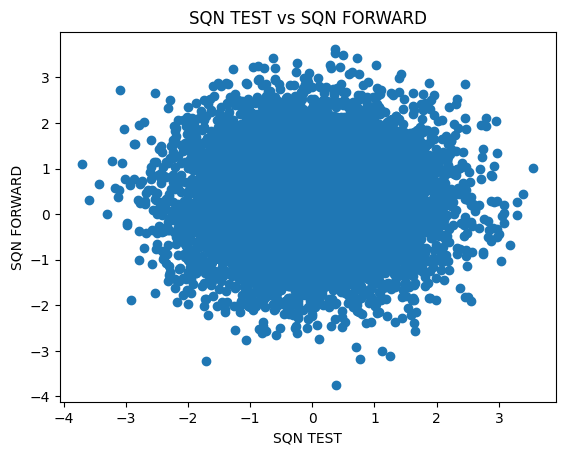

In [ ]:
#RELACIÓN ENTRE EL SQN EN TEST Y EL SQN EN OUT OF SAMPLE

#Generar gráfico
plt.scatter(df_est["SQN"], df_est["SQN_FORWARD"])
plt.xlabel("SQN TEST")
plt.ylabel("SQN FORWARD")
plt.title("SQN TEST vs SQN FORWARD")
plt.show()